In [47]:
import numpy as np
import scipy.ndimage.morphology as snm
from skimage.measure import label, regionprops
from skimage.feature import canny
from skimage.transform import (rotate, hough_circle)
from skimage import io, color, morphology, filters
import matplotlib.pyplot as plt

def YYZZ(file_name):
    # seal to matrix
    NOMINAL_ANGLE = 8
    
    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
    img = io.imread(file_name)

    ##################### red seal detection ####################
    r = img[:,:,0]
    seal_mask = img[:,:,0].astype(int) - np.maximum(img[:,:,1], img[:,:,2]).astype(int) > 20
    
    se_disk0 = morphology.disk(2)
    se_disk1 = morphology.disk(25)
    
    seal_mask = morphology.closing(seal_mask, se_disk0)
    seal_mask = snm.binary_fill_holes(seal_mask, structure=se_disk0)
    seal_mask = morphology.opening(seal_mask, se_disk1)
    seal_edge = canny(seal_mask, 0.25)
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    radii = np.arange(np.int(img_width/20), np.int(img_width/6))
    hspaces = hough_circle(seal_mask, radii)
    
    # seal's center and radius' index
    ridx, seal_row, seal_col = np.unravel_index(np.argmax(hspaces), hspaces.shape)
    Radius = radii[ridx]
    print('circles')
    print('ctr_y, ctr_x, and radius', seal_row, seal_col, Radius)
    
    
    bw = color.rgb2gray(img)
    val = filters.threshold_otsu(r)
    bw = r < val
    print('val', val)
    
    #
    #########################  martix ##########################
    #
    r_close = morphology.closing(r, morphology.disk(5))
    r_open = morphology.opening(r, morphology.disk(5))

    r_var = r_close - r_open > 80
    r_var = morphology.binary_closing(r_var, morphology.disk(3))
    r_var = morphology.binary_opening(r_var, morphology.square(img_width/40))
    
    #bw = morphology.binary_closing(bw, se_disk1)
    #edges = canny(bw, 1)
    
    result = seal_mask + r_var
    
    
    label_img = label(r_var, connectivity=2, background=0)
    props = regionprops(label_img)
   
    # get the matrix
    index = 0
    MATRIX_RATIO = 1
    closest_ratio = 0
    for i in np.arange(len(props)):
        blob = props[i]
        ratio = blob.minor_axis_length/blob.major_axis_length
        if blob.area > Radius*Radius:
            if abs(closest_ratio - MATRIX_RATIO) > abs(ratio - MATRIX_RATIO):
                closest_ratio = ratio
                index = i
    
    matrix_mark = label_img == index + 1  # label index is 1 based, props is 0 based
    
    matrix_row = props[index].centroid[0]
    matrix_col = props[index].centroid[1]
    
    
    marker_vec = np.array([seal_col - matrix_col, seal_row - matrix_row])
    marker_norm = np.linalg.norm(marker_vec) + 0.5
    marker_unit_vec = marker_vec/marker_norm
    
    marker_angle = np.arccos(np.clip(np.dot(marker_unit_vec, np.array([1,0])), -1.0, 1.0))
    marker_angle = 180*marker_angle/3.1416       # in degree
    
    ##################### first cropping ######################
    UP_SCALE = 2.
    DOWN_SCALE = 0.35
    LEFT_SCALE = 0.5
    RIGHT_SCALE = 0.40
    
    A = NOMINAL_ANGLE*np.pi/180
    parellel_col = matrix_col + \
                    marker_norm*(np.cos(-A)*marker_unit_vec[0] - np.sin(-A)*marker_unit_vec[1])
    parellel_row = matrix_row + \
                    marker_norm*(np.sin(-A)*marker_unit_vec[0] + np.cos(-A)*marker_unit_vec[1])
    
    bottom_vec_col = np.cos(-A)*marker_unit_vec[0] - np.sin(-A)*marker_unit_vec[1]
    bottom_vec_row = np.sin(-A)*marker_unit_vec[0] + np.cos(-A)*marker_unit_vec[1]
    bottom_vec = np.array([bottom_vec_col, bottom_vec_row])
    vertical_vec = np.array([bottom_vec_row, -bottom_vec_col])
                             
    print('marker norm', marker_norm)
    print('marker vector', marker_unit_vec)
    print('matrix center', matrix_col, matrix_row)
    print('seal center', seal_col, seal_row)
    print('parellel pt', parellel_col, parellel_row)
    
    matrix_ctr = np.array([matrix_col, matrix_row])
    
    pt_ul = (matrix_ctr + UP_SCALE*marker_norm*vertical_vec-LEFT_SCALE*marker_norm*bottom_vec).astype(int)
    pt_dl = (matrix_ctr - DOWN_SCALE*marker_norm*vertical_vec - LEFT_SCALE*marker_norm*bottom_vec).astype(int)
    pt_ur = (matrix_ctr + UP_SCALE*marker_norm*vertical_vec + (1+RIGHT_SCALE)*marker_norm*bottom_vec).astype(int)
    pt_dr = (matrix_ctr - DOWN_SCALE*marker_norm*vertical_vec + (1+RIGHT_SCALE)*marker_norm*bottom_vec).astype(int)

    bbx_min = np.min([pt_ul, pt_dl, pt_ur, pt_dr, [img.shape[1], img.shape[0]]], axis=0)
    bbx_max = np.max([pt_ul, pt_dl, pt_ur, pt_dr, [0, 0]], axis=0)
    
    '''
    print('min', bbx_min[0], bbx_min[1])
    print('max', bbx_max[0], bbx_max[1])
    
    print('ul', pt_ul)
    print('dl', pt_dl)
    print('ur', pt_ur)
    print('dr', pt_dr)
    '''
    
    img = img[bbx_min[1]:bbx_max[1], bbx_min[0]:bbx_max[0], :]
    
    # ALIGNMENT 
    
    img_aligned = rotate(img, marker_angle-NOMINAL_ANGLE, resize=True)
    
    # align
    H = img_aligned.shape[0]
    W = img_aligned.shape[1]
    
    img_cropped = img_aligned[np.int(0.33*H):np.int(0.66*H),
                              np.int(0.55*(W-marker_norm)):np.int(0.5*(W+marker_norm)),:]
    
    img_cropped = color.rgb2gray(img_cropped)
    val = filters.threshold_otsu(img_cropped)
    img_cropped = img_cropped < val
    
    se = morphology.rectangle(1, 15)
    img_cropped = morphology.dilation(img_cropped, se)
    
    label_img = label(img_cropped, connectivity=2, background=0)
    props = regionprops(label_img)
    
    orints = np.array(np.zeros([label_img.max()]))        # placeholder for orientations
    i = 0
    for blob in props:
        if blob.minor_axis_length/(blob.major_axis_length+1) < 0.2:
            orints[i] = blob.orientation
            i += 1

    theta = np.median(orints[:i])*180/np.pi # rotation angle
    img_cropped = rotate(img_aligned, -theta, resize=False)
    
    ####################### cropping ##################
    alpha = 0.99
    width = alpha*(1 + LEFT_SCALE + RIGHT_SCALE)*marker_norm
    height = alpha*(UP_SCALE + DOWN_SCALE)*marker_norm
    
    half_w_delta = np.maximum(0, 0.5*(img_cropped.shape[1] - width)).astype(int)
    half_h_delta = np.maximum(0, 0.5*(img_cropped.shape[0] - height)).astype(int)
    
    img_cropped = img_cropped[half_h_delta:-half_h_delta, half_w_delta:-half_w_delta,:]
    img = io.imread(file_name)
    ax[0].imshow(img)
    ax[0].set_title('Original')
    ax[1].imshow(img_cropped)
    ax[1].set_title('Cropped')
    ax[2].imshow(label_img)
    ax[3].imshow(r_var)

    plt.show()
    return img_cropped

circles
ctr_y, ctr_x, and radius 816 442 55
val 113


C:\Users\Yi\Anaconda3\lib\site-packages\numpy\core\numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


marker norm 334.428233073
marker vector [ 0.98053067  0.18860451]
matrix center 114.082860262 752.925327511
seal center 442 816
parellel pt 447.5870307 769.748916428


C:\Users\Yi\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  'left=%s, right=%s') % (left, right))


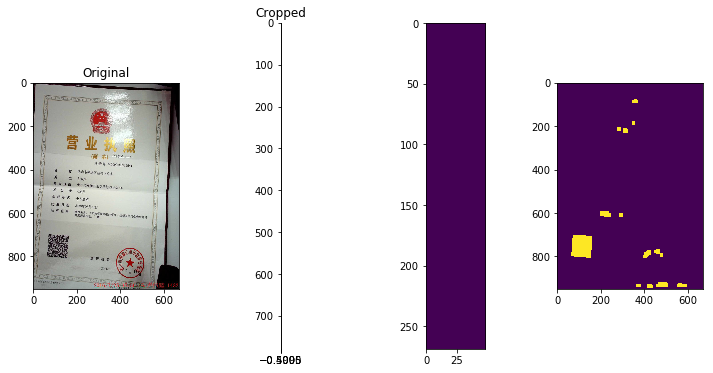

In [48]:
imgOut = YYZZ('C:\\Projects\\Matlab\\I2T\\permit01.jpg')


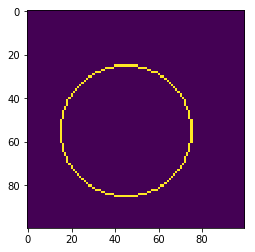

(55, 45, 30)

In [455]:
from skimage.transform import hough_circle
from skimage.draw import circle_perimeter
img = np.zeros((100, 100), dtype=np.bool_)
x0, y0, R = 45, 55, 30
rr, cc = circle_perimeter(y0, x0, R)
img[rr, cc] = 1
try_radii = np.arange(5, 35)
res = hough_circle(img, try_radii)
plt.imshow(img)
plt.show()
ridx, r, c = np.unravel_index(np.argmax(res), res.shape)
r, c, try_radii[ridx]

In [343]:
from scipy.ndimage.filters import gaussian_filter
import numpy as np
from skimage.filter import canny
from skimage.transform import (rotate, hough_circle)
from skimage import io, color, morphology, filters
import matplotlib.pyplot as plt

def BackgroundAdjust(file_name, default_brightness, shift=10):
    
    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
    img = io.imread(file_name)
    
    bw0 = color.rgb2gray(img)
    val = filters.threshold_otsu(bw0)
    bw = bw0 < val
    
    se_square = np.ones([25,25])
    se_disc = morphology.disk(25)
    
    #bw = morphology.binary_opening(bw, se0) #.astype(np.uint8)
    bw_square = morphology.closing(bw0, se_square)
    bw_disc = morphology.closing(bw0, se_disc)
    bw_gauss = gaussian_filter(bw_disc, sigma=5)
    
    default_brightness = max(default_brightness, 200)
    default_brightness = min(default_brightness, 220)
    
    alpha = np.ones(bw.shape).astype(float)
    alpha = default_brightness/255/(bw_disc + shift/255)
    print('bw_disc', np.min(bw_disc), np.max(bw_disc))
    print(alpha.shape, np.min(alpha), np.max(alpha))
    
    imgOut = img.astype(float)
    
    imgOut[:,:,0] = alpha*imgOut[:,:,0]
    imgOut[:,:,1] = alpha*imgOut[:,:,1]
    imgOut[:,:,2] = alpha*imgOut[:,:,2]
    imgOut = np.uint8(imgOut)
    
    ax[0].imshow(img)
    ax[1].imshow(bw0)
    ax[2].imshow(alpha)
    ax[3].imshow(imgOut)
    plt.show()
    return imgOut

bw_disc 0.454985882353 0.984210980392
(1216, 851) 0.827149140254 1.6791150148


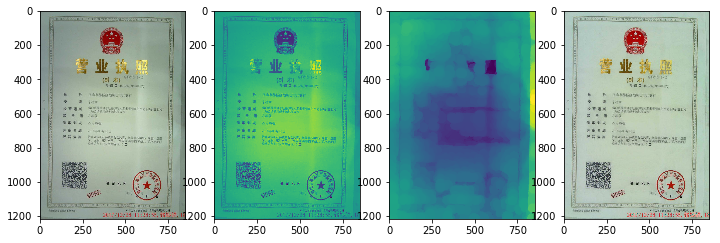

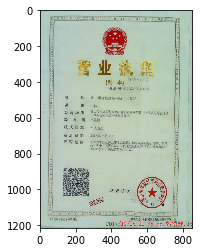

In [345]:
imgOut = BackgroundAdjust('C:\\Projects\\Matlab\\I2T\\permit04.jpg', 250, 15)
bw = 
plt.imshow(imgOut)
plt.show()

In [307]:
import skimage
a = np.array([[1,2,1],[3,2,3]])
print(np.max(a))
print(a.shape[1])
print(np.arange(3,5))
print(skimage.__version__)


3
3
[3 4]
0.12.3


In [585]:
a = np.array([1, 2, 1])
print(a)
b = np.min([a, a-1, a+1], axis=0)
print(b)

[1 2 1]
[0 1 0]


In [525]:
print(np.median(a))

-0.144580898081


In [50]:
12*3600/32

1350.0